<a href="https://colab.research.google.com/github/ecthompsoncodes/FDS-Epi-Project/blob/main/Epi_NN_Model_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split,  TensorDataset
from sklearn.model_selection import train_test_split
import random
# !pip install optuna
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# set seed for consistency in results
torch.manual_seed(44)
np.random.seed(44)
random.seed(44)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(44)

In [13]:
# read in most updated data file
data = pd.read_csv("data_412.csv")

data.head()

,Unnamed: 0,cases,county,date_number,Population,region,pop_dens,crime_per_100k,tranlevel,Longitude,Latitude,tranlevel_in_2_weeks
0,18100,19035,Alamance,1,175029.0,Northern,404.8,3065.6,Moderate,-79.399425,36.043710,Moderate
1,18182,3908,Scotland,1,33662.0,Eastern,107.1,3528.0,Moderate,-79.480429,34.840885,Substantial
2,18131,25979,Durham,1,331347.0,Eastern,1133.7,3966.0,Moderate,-78.876593,36.036030,Moderate
3,18110,18087,Buncombe,1,271638.0,Western,410.4,3012.8,Low,-82.530107,35.611178,Moderate
4,18181,8160,Sampson,1,58371.0,Coastal,62.4,2241.9,Moderate,-78.371391,34.991536,Moderate


In [14]:
# deal with categorical variables

# one-hot encoding for non-ordinal variables
non_ordinal_features = ['county', 'region']
data = pd.get_dummies(data, columns=non_ordinal_features, prefix=non_ordinal_features, drop_first=False, dtype=int)
# drop_first = False to keep all categories

# ordinal encoding for ordinal features
ordinal_features = ['tranlevel', 'tranlevel_in_2_weeks']
# make sure categories are the same for both tranlevel and tranlevel_in_2_weeks
ordinal_categories = {
    'tranlevel': ['Low', 'Moderate', 'Substantial', 'High'],
    'tranlevel_in_2_weeks': ['Low', 'Moderate', 'Substantial', 'High']
}
for feature, categories in ordinal_categories.items():
    data[feature] = pd.Categorical(data[feature], categories=categories, ordered=True).codes

# clean out identification column

data = data.iloc[:, 1:]
data.head()

,cases,date_number,Population,pop_dens,crime_per_100k,tranlevel,Longitude,Latitude,tranlevel_in_2_weeks,county_Alamance,...,county_Wayne,county_Wilkes,county_Wilson,county_Yadkin,county_Yancey,region_Central,region_Coastal,region_Eastern,region_Northern,region_Western
0,19035,1,175029.0,404.8,3065.6,1,-79.399425,36.043710,1,1,...,0,0,0,0,0,0,0,0,1,0
1,3908,1,33662.0,107.1,3528.0,1,-79.480429,34.840885,2,0,...,0,0,0,0,0,0,0,1,0,0
2,25979,1,331347.0,1133.7,3966.0,1,-78.876593,36.036030,1,0,...,0,0,0,0,0,0,0,1,0,0
3,18087,1,271638.0,410.4,3012.8,0,-82.530107,35.611178,1,0,...,0,0,0,0,0,0,0,0,0,1
4,8160,1,58371.0,62.4,2241.9,1,-78.371391,34.991536,1,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
# split data according to time

data = data.sort_values(by = "date_number")

train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]


In [16]:
# separate X and Y variables
# get a list of all columns except 'tranlevel_in_2_weeks'
feature_cols = [col for col in data.columns if col != 'tranlevel_in_2_weeks']

X_train = train_data[feature_cols]
y_train = train_data['tranlevel_in_2_weeks'] # we are trying to predict transmission level in 2 weeks

X_test = test_data[feature_cols]
y_test = test_data['tranlevel_in_2_weeks']

X_val = val_data[feature_cols]
y_val = val_data['tranlevel_in_2_weeks']

In [17]:
# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# shuffle = True ensures that data is shuffled before each epoch, so that batches contain different combos of data points in each epoch
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

input_dim = X_train.shape[1]

In [31]:
# define the objective function for Optuna for automatic hyperparameter tuning
def objective(trial):
    # suggest values for hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)  # search for hidden_dim
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)  # dropout between 0.0 and 0.5
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])  # optimizer choices

    # define the model
    class EpiNN(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(EpiNN, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
            self.fc4 = nn.Linear(hidden_dim // 4, hidden_dim // 8)
            self.output = nn.Linear(hidden_dim // 8, 1)

            self.dropout = nn.Dropout(dropout_rate)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)
            self.batch_norm3 = nn.BatchNorm1d(hidden_dim // 4)
            self.batch_norm4 = nn.BatchNorm1d(hidden_dim // 8)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.batch_norm1(x)
            x = self.dropout(x)

            x = F.relu(self.fc2(x))
            x = self.batch_norm2(x)
            x = self.dropout(x)

            x = F.relu(self.fc3(x))
            x = self.batch_norm3(x)
            x = self.dropout(x)

            x = F.relu(self.fc4(x))
            x = self.batch_norm4(x)
            x = self.dropout(x)

            x = self.output(x)
            return x

    # model, criterion, and optimizer
    model = EpiNN(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
    criterion = nn.L1Loss()  # MAE as the loss function
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    # early stopping parameters
    patience = 5
    min_delta = 0.01
    best_val_loss = float('inf')
    patience_counter = 0

    # training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_train_targets = []
        all_train_predictions = []

        for batch_features, batch_targets in train_loader:
            batch_features = batch_features.float().to(device)
            batch_targets = batch_targets.float().to(device)

            optimizer.zero_grad()
            predictions = model(batch_features).squeeze(1)
            loss = criterion(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_features.size(0)

            # collect predictions and targets for F1-score
            rounded_predictions = torch.round(predictions).detach().cpu().numpy()
            clamped_predictions = np.clip(rounded_predictions, 0, 4)
            all_train_predictions.extend(clamped_predictions)
            all_train_targets.extend(batch_targets.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_f1 = f1_score(all_train_targets, all_train_predictions, average="weighted", zero_division=0)

        # validation phase
        model.eval()
        val_loss = 0.0
        all_val_targets = []
        all_val_predictions = []

        with torch.no_grad():
            for batch_features, batch_targets in valid_loader:
                batch_features = batch_features.float().to(device)
                batch_targets = batch_targets.float().to(device)

                predictions = model(batch_features).squeeze(1)
                loss = criterion(predictions, batch_targets)
                val_loss += loss.item() * batch_features.size(0)

                # collect predictions and targets for F1-score
                rounded_predictions = torch.round(predictions).cpu().numpy()
                clamped_predictions = np.clip(rounded_predictions, 0, 8)
                all_val_predictions.extend(clamped_predictions)
                all_val_targets.extend(batch_targets.cpu().numpy())

        val_loss /= len(valid_loader.dataset)
        val_f1 = f1_score(all_val_targets, all_val_predictions, average="weighted", zero_division=0)

        # print metrics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1-Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation F1-Score: {val_f1:.4f}")

        # early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter if improvement is observed


            # save the best model
            torch.save(model.state_dict(), f"best_model_trial_{trial.number}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        # report metrics to Optuna
        trial.report(val_f1, epoch)  # report F1-score as the metric
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # return validation F1-score as the objective value
    return val_f1

# run Optuna study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=15)

# best trial
print("Best trial:")
print(study.best_trial.params)


[I 2025-01-18 21:25:51,469] A new study created in memory with name: no-name-33118c90-b08b-4240-97eb-fac97be7c1f2
<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.4200, Train F1-Score: 0.7642
Validation Loss: 26.2057, Validation F1-Score: 0.6785
Epoch 2/50
Train Loss: 0.2363, Train F1-Score: 0.7925
Validation Loss: 2101.9762, Validation F1-Score: 0.6753
Epoch 3/50
Train Loss: 0.2290, Train F1-Score: 0.7927
Validation Loss: 272.2940, Validation F1-Score: 0.6735
Epoch 4/50
Train Loss: 0.2297, Train F1-Score: 0.7927
Validation Loss: 91.0592, Validation F1-Score: 0.6766
Epoch 5/50
Train Loss: 0.2246, Train F1-Score: 0.7927
Validation Loss: 41.9398, Validation F1-Score: 0.6718
Epoch 6/50
Train Loss: 0.2236, Train F1-Score: 0.7926
Validation Loss: 17.5755, Validation F1-Score: 0.6764
Epoch 7/50
Train Loss: 0.2226, Train F1-Score: 0.7927
Validation Loss: 40.7825, Validation F1-Score: 0.6716
Epoch 8/50
Train Loss: 0.2216, Train F1-Score: 0.7927
Validation Loss: 13.0486, Validation F1-Score: 0.6763
Epoch 9/50
Train Loss: 0.2211, Train F1-Score: 0.7927
Validation Loss: 5.2631, Validation F1-Score: 0.6758
Epoch 10/50
Train Loss: 0.

[I 2025-01-18 21:26:46,687] Trial 0 finished with value: 0.6789345063538611 and parameters: {'hidden_dim': 128, 'dropout': 0.0, 'lr': 0.0033284082350828375, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 14/50
Train Loss: 0.2206, Train F1-Score: 0.7931
Validation Loss: 230188.2611, Validation F1-Score: 0.6789
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.8069, Train F1-Score: 0.5743
Validation Loss: 0.3547, Validation F1-Score: 0.6787
Epoch 2/50
Train Loss: 0.4235, Train F1-Score: 0.7497
Validation Loss: 0.2835, Validation F1-Score: 0.6859
Epoch 3/50
Train Loss: 0.3342, Train F1-Score: 0.7899
Validation Loss: 0.2639, Validation F1-Score: 0.6787
Epoch 4/50
Train Loss: 0.2700, Train F1-Score: 0.7927
Validation Loss: 0.2631, Validation F1-Score: 0.6787
Epoch 5/50
Train Loss: 0.2272, Train F1-Score: 0.7927
Validation Loss: 0.2691, Validation F1-Score: 0.6787
Epoch 6/50
Train Loss: 0.2183, Train F1-Score: 0.7927
Validation Loss: 0.2623, Validation F1-Score: 0.6787
Epoch 7/50
Train Loss: 0.2170, Train F1-Score: 0.7927
Validation Loss: 0.2635, Validation F1-Score: 0.6787


[I 2025-01-18 21:27:20,424] Trial 1 finished with value: 0.678743066009829 and parameters: {'hidden_dim': 224, 'dropout': 0.4, 'lr': 0.002405904875241864, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 8/50
Train Loss: 0.2152, Train F1-Score: 0.7927
Validation Loss: 0.2613, Validation F1-Score: 0.6787
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 1.4296, Train F1-Score: 0.4709
Validation Loss: 0.3282, Validation F1-Score: 0.6880
Epoch 2/50
Train Loss: 0.2428, Train F1-Score: 0.7925
Validation Loss: 0.2929, Validation F1-Score: 0.6880
Epoch 3/50
Train Loss: 0.2288, Train F1-Score: 0.7927
Validation Loss: 0.3020, Validation F1-Score: 0.6792
Epoch 4/50
Train Loss: 0.2241, Train F1-Score: 0.7927
Validation Loss: 0.3734, Validation F1-Score: 0.6792
Epoch 5/50
Train Loss: 0.2219, Train F1-Score: 0.7927
Validation Loss: 0.2727, Validation F1-Score: 0.6787
Epoch 6/50
Train Loss: 0.2206, Train F1-Score: 0.7927
Validation Loss: 0.2696, Validation F1-Score: 0.6787
Epoch 7/50
Train Loss: 0.2198, Train F1-Score: 0.7927
Validation Loss: 0.2909, Validation F1-Score: 0.6792
Epoch 8/50
Train Loss: 0.2190, Train F1-Score: 0.7927
Validation Loss: 0.2715, Validation F1-Score: 0.6787
Epoch 9/50
Train Loss: 0.2187, Train F1-Score: 0.7927
Validation Loss: 0.3041, Validation F1-Score: 0.6792


[I 2025-01-18 21:27:59,643] Trial 2 finished with value: 0.678743066009829 and parameters: {'hidden_dim': 64, 'dropout': 0.0, 'lr': 0.0005077712271436666, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 10/50
Train Loss: 0.2184, Train F1-Score: 0.7927
Validation Loss: 0.2707, Validation F1-Score: 0.6787
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 2.4386, Train F1-Score: 0.0127
Validation Loss: 1.4837, Validation F1-Score: 0.1404
Epoch 2/50
Train Loss: 0.9498, Train F1-Score: 0.4347
Validation Loss: 0.6499, Validation F1-Score: 0.6812
Epoch 3/50
Train Loss: 0.2757, Train F1-Score: 0.7928
Validation Loss: 0.3723, Validation F1-Score: 0.6803
Epoch 4/50
Train Loss: 0.2504, Train F1-Score: 0.7925
Validation Loss: 0.3273, Validation F1-Score: 0.6803
Epoch 5/50
Train Loss: 0.2376, Train F1-Score: 0.7927
Validation Loss: 0.3154, Validation F1-Score: 0.6831
Epoch 6/50
Train Loss: 0.2327, Train F1-Score: 0.7927
Validation Loss: 0.3781, Validation F1-Score: 0.6763
Epoch 7/50
Train Loss: 0.2295, Train F1-Score: 0.7927
Validation Loss: 0.3374, Validation F1-Score: 0.6763
Epoch 8/50
Train Loss: 0.2270, Train F1-Score: 0.7927
Validation Loss: 0.3007, Validation F1-Score: 0.6831
Epoch 9/50
Train Loss: 0.2253, Train F1-Score: 0.7927
Validation Loss: 0.2963, Validation F1-Score: 0.6859
Epoch 10/50
Train Loss: 0.2240, Train

[I 2025-01-18 21:29:11,153] Trial 3 finished with value: 0.678743066009829 and parameters: {'hidden_dim': 160, 'dropout': 0.0, 'lr': 0.00013236026409963874, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 18/50
Train Loss: 0.2200, Train F1-Score: 0.7927
Validation Loss: 0.2843, Validation F1-Score: 0.6787
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.8841, Train F1-Score: 0.5509
Validation Loss: 0.3661, Validation F1-Score: 0.6787
Epoch 2/50
Train Loss: 0.3757, Train F1-Score: 0.7722
Validation Loss: 0.2776, Validation F1-Score: 0.6787
Epoch 3/50
Train Loss: 0.2270, Train F1-Score: 0.7927
Validation Loss: 0.2602, Validation F1-Score: 0.6787
Epoch 4/50
Train Loss: 0.2147, Train F1-Score: 0.7927
Validation Loss: 0.2611, Validation F1-Score: 0.6787
Epoch 5/50
Train Loss: 0.2146, Train F1-Score: 0.7927
Validation Loss: 0.2604, Validation F1-Score: 0.6787
Epoch 6/50
Train Loss: 0.2146, Train F1-Score: 0.7927
Validation Loss: 0.2600, Validation F1-Score: 0.6787
Epoch 7/50
Train Loss: 0.2144, Train F1-Score: 0.7927
Validation Loss: 0.2606, Validation F1-Score: 0.6787


[I 2025-01-18 21:29:44,448] Trial 4 finished with value: 0.678743066009829 and parameters: {'hidden_dim': 32, 'dropout': 0.30000000000000004, 'lr': 0.0030275607862926225, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 8/50
Train Loss: 0.2143, Train F1-Score: 0.7927
Validation Loss: 0.2599, Validation F1-Score: 0.6787
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.9240, Train F1-Score: 0.6138
Validation Loss: 1.6785, Validation F1-Score: 0.6802
Epoch 2/50
Train Loss: 0.2540, Train F1-Score: 0.7921
Validation Loss: 0.6664, Validation F1-Score: 0.6957
Epoch 3/50
Train Loss: 0.2392, Train F1-Score: 0.7925
Validation Loss: 0.3831, Validation F1-Score: 0.6918
Epoch 4/50
Train Loss: 0.2336, Train F1-Score: 0.7927
Validation Loss: 0.9301, Validation F1-Score: 0.6789
Epoch 5/50
Train Loss: 0.2301, Train F1-Score: 0.7927
Validation Loss: 0.4948, Validation F1-Score: 0.6762
Epoch 6/50
Train Loss: 0.2258, Train F1-Score: 0.7927
Validation Loss: 3.7486, Validation F1-Score: 0.6760
Epoch 7/50
Train Loss: 0.2247, Train F1-Score: 0.7927
Validation Loss: 2.2711, Validation F1-Score: 0.6760


[I 2025-01-18 21:30:16,335] Trial 5 finished with value: 0.6760236511456024 and parameters: {'hidden_dim': 64, 'dropout': 0.0, 'lr': 0.0007517904565610455, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 8/50
Train Loss: 0.2237, Train F1-Score: 0.7927
Validation Loss: 0.9035, Validation F1-Score: 0.6760
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.5811, Train F1-Score: 0.6998
Validation Loss: 0.2843, Validation F1-Score: 0.6787


[I 2025-01-18 21:30:25,067] Trial 6 pruned. 


Epoch 2/50
Train Loss: 0.3320, Train F1-Score: 0.7886
Validation Loss: 0.2775, Validation F1-Score: 0.6787


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 1.4324, Train F1-Score: 0.3076
Validation Loss: 0.4790, Validation F1-Score: 0.6872
Epoch 2/50
Train Loss: 0.6716, Train F1-Score: 0.5679
Validation Loss: 0.3684, Validation F1-Score: 0.6784
Epoch 3/50
Train Loss: 0.5466, Train F1-Score: 0.6520
Validation Loss: 0.3889, Validation F1-Score: 0.6872
Epoch 4/50
Train Loss: 0.4726, Train F1-Score: 0.7111
Validation Loss: 0.3422, Validation F1-Score: 0.6784
Epoch 5/50
Train Loss: 0.4229, Train F1-Score: 0.7483
Validation Loss: 0.3303, Validation F1-Score: 0.6784
Epoch 6/50
Train Loss: 0.3825, Train F1-Score: 0.7724
Validation Loss: 0.3156, Validation F1-Score: 0.6792
Epoch 7/50
Train Loss: 0.3479, Train F1-Score: 0.7856
Validation Loss: 0.3086, Validation F1-Score: 0.6790
Epoch 8/50
Train Loss: 0.3160, Train F1-Score: 0.7916
Validation Loss: 0.2953, Validation F1-Score: 0.6787
Epoch 9/50
Train Loss: 0.2870, Train F1-Score: 0.7927
Validation Loss: 0.2779, Validation F1-Score: 0.6795
Epoch 10/50
Train Loss: 0.2596, Train

[I 2025-01-18 21:31:32,492] Trial 7 finished with value: 0.678743066009829 and parameters: {'hidden_dim': 128, 'dropout': 0.4, 'lr': 0.0006231516211484649, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 16/50
Train Loss: 0.2146, Train F1-Score: 0.7927
Validation Loss: 0.2599, Validation F1-Score: 0.6787
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.5415, Train F1-Score: 0.7170
Validation Loss: 0.3860, Validation F1-Score: 0.6787


[I 2025-01-18 21:31:41,169] Trial 8 pruned. 


Epoch 2/50
Train Loss: 0.3354, Train F1-Score: 0.7885
Validation Loss: 0.2970, Validation F1-Score: 0.6787


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate
[I 2025-01-18 21:31:45,131] Trial 9 pruned. 


Epoch 1/50
Train Loss: 0.5886, Train F1-Score: 0.6720
Validation Loss: 0.3382, Validation F1-Score: 0.6783


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate


Epoch 1/50
Train Loss: 0.5625, Train F1-Score: 0.7148
Validation Loss: 0.2783, Validation F1-Score: 0.6859
Epoch 2/50
Train Loss: 0.2522, Train F1-Score: 0.7902
Validation Loss: 0.2800, Validation F1-Score: 0.6787
Epoch 3/50
Train Loss: 0.2309, Train F1-Score: 0.7927
Validation Loss: 0.2671, Validation F1-Score: 0.6787
Epoch 4/50
Train Loss: 0.2297, Train F1-Score: 0.7927
Validation Loss: 0.2696, Validation F1-Score: 0.6787
Epoch 5/50
Train Loss: 0.2287, Train F1-Score: 0.7927
Validation Loss: 0.2741, Validation F1-Score: 0.6787
Epoch 6/50
Train Loss: 0.2284, Train F1-Score: 0.7927
Validation Loss: 0.2665, Validation F1-Score: 0.6787
Epoch 7/50
Train Loss: 0.2277, Train F1-Score: 0.7927
Validation Loss: 0.2746, Validation F1-Score: 0.6786


[I 2025-01-18 21:32:15,089] Trial 10 finished with value: 0.6784062309245433 and parameters: {'hidden_dim': 128, 'dropout': 0.1, 'lr': 0.009609424004143163, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6789345063538611.


Epoch 8/50
Train Loss: 0.2275, Train F1-Score: 0.7927
Validation Loss: 0.2823, Validation F1-Score: 0.6784
Early stopping triggered


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate
[I 2025-01-18 21:32:19,377] Trial 11 pruned. 


Epoch 1/50
Train Loss: 1.6905, Train F1-Score: 0.1807
Validation Loss: 0.5303, Validation F1-Score: 0.6616


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate
[I 2025-01-18 21:32:23,371] Trial 12 pruned. 


Epoch 1/50
Train Loss: 0.9604, Train F1-Score: 0.5030
Validation Loss: 0.4109, Validation F1-Score: 0.6787


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate
[I 2025-01-18 21:32:26,990] Trial 13 pruned. 


Epoch 1/50
Train Loss: 1.6725, Train F1-Score: 0.1993
Validation Loss: 0.6696, Validation F1-Score: 0.5212


<ipython-input-31-4a113662c8b9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # learning rate
[I 2025-01-18 21:32:31,633] Trial 14 pruned. 


Epoch 1/50
Train Loss: 2.1552, Train F1-Score: 0.0605
Validation Loss: 1.1428, Validation F1-Score: 0.0630
Best trial:
{'hidden_dim': 128, 'dropout': 0.0, 'lr': 0.0033284082350828375, 'optimizer': 'AdamW'}


Best parameters: {'hidden_dim': 128, 'dropout': 0.0, 'lr': 0.0033284082350828375, 'optimizer': 'AdamW'}


<ipython-input-34-dfed8252a65a>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimized_model.load_state_dict(torch.load(f"best_model_trial_{best_trial.number}.pt"))


Test Loss: 0.8613
Test F1-Score: 0.6455


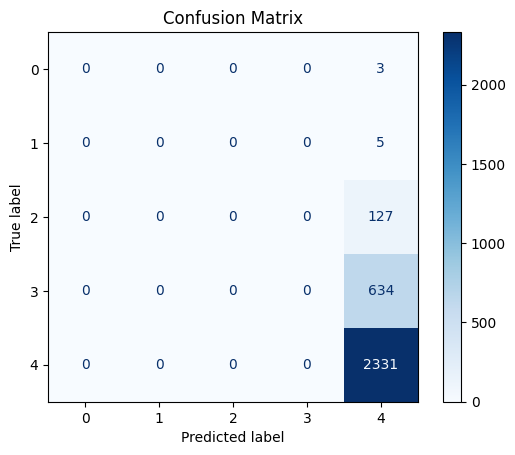

In [34]:
# get the best parameters from the Optuna study
best_trial = study.best_trial
best_params = study.best_trial.params
print("Best parameters:", best_params)

# define the model outside of the Optuna function
class EpiNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(EpiNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, hidden_dim // 8)
        self.output = nn.Linear(hidden_dim // 8, 1)

        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_dim // 4)
        self.batch_norm4 = nn.BatchNorm1d(hidden_dim // 8)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.dropout(x)

        x = F.relu(self.fc4(x))
        x = self.batch_norm4(x)
        x = self.dropout(x)

        x = self.output(x)
        return x
# reinitialize the model with the best parameters from Optuna
optimized_model = EpiNN(input_dim=input_dim, dropout_rate=best_params['dropout'], hidden_dim=best_params['hidden_dim']).to(device)
# load the best model state dictionary
optimized_model.load_state_dict(torch.load(f"best_model_trial_{best_trial.number}.pt"))
optimized_model.eval()

# evaluate on the test set
test_loss = 0.0
all_test_targets = []
all_test_predictions = []

with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features = batch_features.float().to(device)
        batch_targets = batch_targets.float().to(device)

        predictions = optimized_model(batch_features).squeeze(1)
        loss = nn.L1Loss()(predictions, batch_targets)
        test_loss += loss.item() * batch_features.size(0)

        rounded_predictions = torch.round(predictions).cpu().numpy()
        clamped_predictions = np.clip(rounded_predictions, 0, 3)
        all_test_predictions.extend(clamped_predictions)
        all_test_targets.extend(batch_targets.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_f1 = f1_score(all_test_targets, all_test_predictions, average="weighted", zero_division=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

conf_matrix = confusion_matrix(all_test_targets, all_test_predictions)

# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues', values_format='d')  # customize the color map if needed
plt.title("Confusion Matrix")
plt.show()
